# 43A.1-modeling-ARIMA-Aggregate

> Determining iPhone 14 claims through aggregate claims method to predict and subtract out the prediction values of each of the iPhone models until we're left with iPhone 14 predictions.

> This notebook is built off from 43A-modeling-ARIMA-Aggregate, which we've seen is not a viable option. This notebook instead uses log to normalize the data as seen in our stationary test from 43.1-modeling-ARIMA-Stationary-Test notebook.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
import numpy as np
from math import sqrt, exp
import warnings

# Load the data

In [3]:
#Constants/globals
os.chdir('/data/p_dsi/teams2023/team9/')
os.getcwd()

In [4]:
#load the data
data = pd.read_csv("Asurion_clean_data_feature_set.csv")
display(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phone model       11684 non-null  object
 1   phone size        11684 non-null  object
 2   phone color       11684 non-null  object
 3   claim             11684 non-null  int64 
 4   weeks_monday      11684 non-null  object
 5   month             11684 non-null  object
 6   year              11684 non-null  int64 
 7   season            11684 non-null  object
 8   quarter           11684 non-null  object
 9   Holidays_Boolean  11684 non-null  bool  
 10  company           11684 non-null  object
 11  model_group       11684 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1015.6+ KB


None

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
5,apple iphone 11,128gb,yellow,5,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
6,apple iphone 11,256gb,black,24,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
7,apple iphone 11,256gb,green,3,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
8,apple iphone 11,256gb,purple,7,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
9,apple iphone 11,256gb,red,9,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


In [5]:
group_model = data.groupby('model_group')
group_model.first()

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company
model_group,,,,,,,,,,,
iphone 11,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple
iphone 12,apple iphone 12,128gb,black,68,2022-01-24,January,2022,winter,Q1,False,apple
iphone 13,apple iphone 13,128gb,midnight,11,2022-01-24,January,2022,winter,Q1,False,apple
iphone 14,apple iphone 14,128gb,black,7,2022-11-14,November,2022,autumn,Q4,False,apple
iphone se,apple iphone se,128gb,gray,1,2022-01-24,January,2022,winter,Q1,False,apple
iphone x,apple iphone x,256gb,gray,62,2022-01-24,January,2022,winter,Q1,False,apple


   weeks_monday  claim
0    2021-06-28   3273
1    2021-07-05   8536
2    2021-07-12   7942
3    2021-07-19   7873
4    2021-07-26   7762
..          ...    ...
81   2023-01-16  11189
82   2023-01-23  11131
83   2023-01-30   9981
84   2023-02-06  12280
85   2023-02-13   2283

[86 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weeks_monday  86 non-null     object
 1   claim         86 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


None

Text(0.5, 1.0, 'Sum of All iPhone Claims')

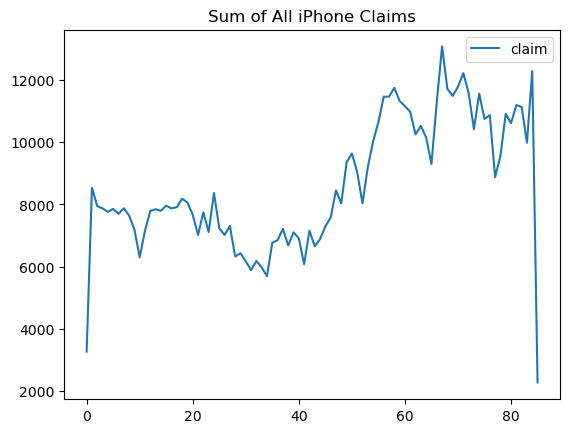

In [6]:
# Summing up all iPhone Claims
result_iphone_all = data.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})

print(result_iphone_all)
display(result_iphone_all.info())
result_iphone_all.plot()
plt.title("Sum of All iPhone Claims")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weeks_monday  85 non-null     object
 1   claim         85 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


None

Text(0.5, 1.0, 'Sum of All iPhone Claims')

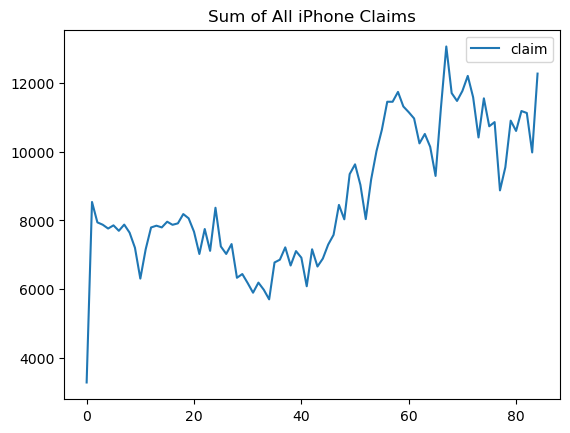

In [7]:
# Removing last data point as recommended by professor and discussed with Asurion client due to possiblity that the data
# recieved is incomplete

result_iphone_all = result_iphone_all[:85]

display(result_iphone_all.info())
result_iphone_all.plot()
plt.title("Sum of All iPhone Claims")

Text(0.5, 1.0, 'iPhone 14')

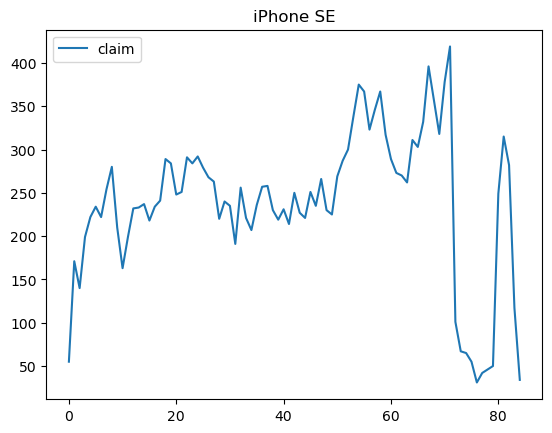

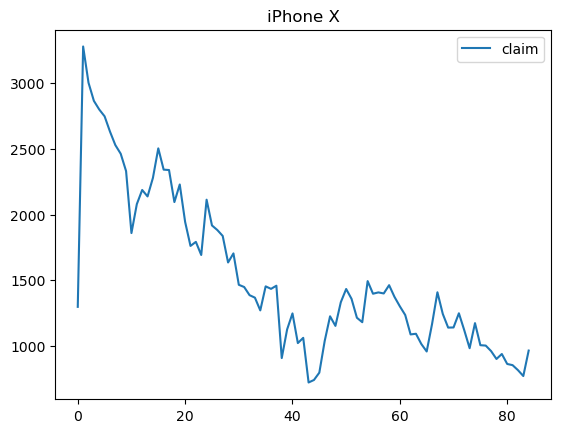

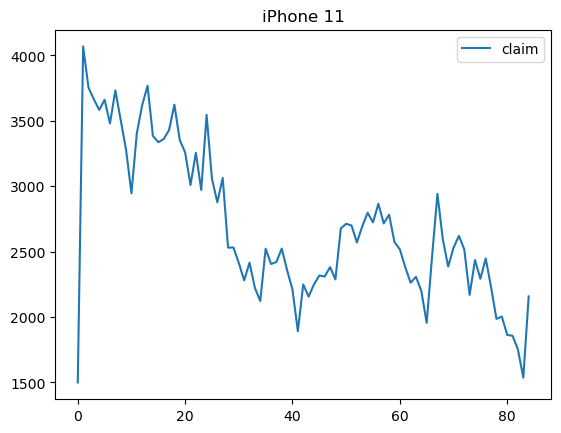

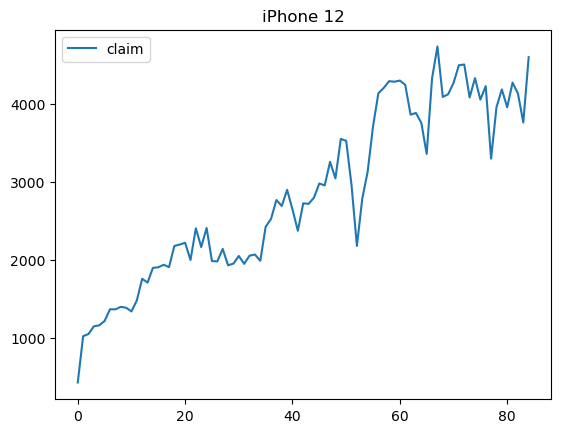

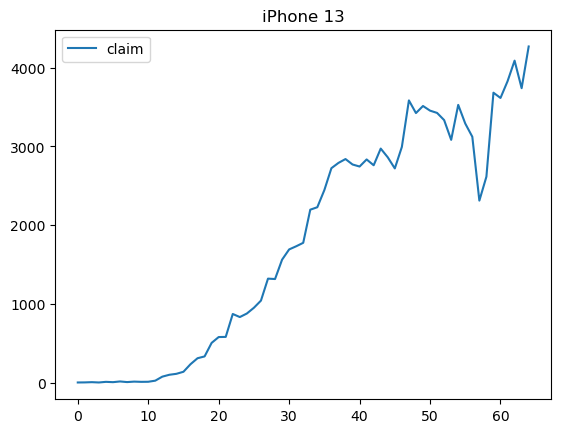

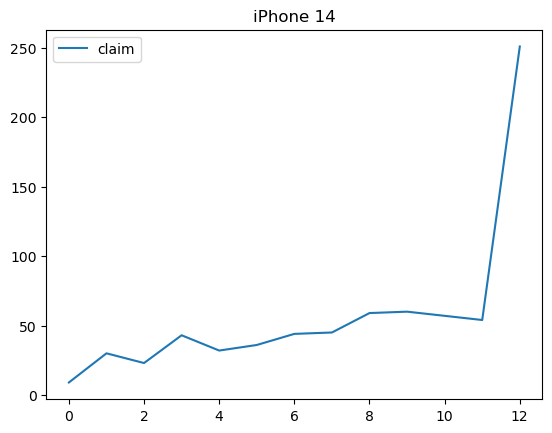

In [8]:
# Removing last data point as recommended by professor and discussed with Asurion client due to possiblity that the data
# recieved is incomplete. This is applied to all models we are looking at

iphonese = data[data["model_group"] == "iphone se"]
result_iphone_se = iphonese.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_se = result_iphone_se[:-1]

iphonex = data[data["model_group"] == "iphone x"]
result_iphone_x = iphonex.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_x = result_iphone_x[:-1]

iphone11 = data[data["model_group"] == "iphone 11"]
result_iphone_11 = iphone11.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_11 = result_iphone_11[:-1]

iphone12 = data[data["model_group"] == "iphone 12"]
result_iphone_12 = iphone12.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_12 = result_iphone_12[:-1]

iphone13 = data[data["model_group"] == "iphone 13"]
result_iphone_13 = iphone13.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_13 = result_iphone_13[:65]

# Reduced the final iPhone 14 data point to maintain consistency with all other models
iphone14 = data[data["model_group"] == "iphone 14"]
result_iphone_14 = iphone14.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})
result_iphone_14 = result_iphone_14[:-1]

result_iphone_se.plot()
plt.title("iPhone SE")
result_iphone_x.plot()
plt.title("iPhone X")
result_iphone_11.plot()
plt.title("iPhone 11")
result_iphone_12.plot()
plt.title("iPhone 12")
result_iphone_13.plot()
plt.title("iPhone 13")
result_iphone_14.plot()
plt.title("iPhone 14")

In [9]:
result_iphone_se['weeks_monday'] = pd.to_datetime(result_iphone_se['weeks_monday'])
result_iphone_se.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_se so it can use the weeks_monday

result_iphone_x['weeks_monday'] = pd.to_datetime(result_iphone_x['weeks_monday'])
result_iphone_x.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_x so it can use the weeks_monday

result_iphone_11['weeks_monday'] = pd.to_datetime(result_iphone_11['weeks_monday'])
result_iphone_11.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_11 so it can use the weeks_monday

result_iphone_12['weeks_monday'] = pd.to_datetime(result_iphone_12['weeks_monday'])
result_iphone_12.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_12 so it can use the weeks_monday

result_iphone_13['weeks_monday'] = pd.to_datetime(result_iphone_13['weeks_monday'])
result_iphone_13.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_13 so it can use the weeks_monday

result_iphone_14['weeks_monday'] = pd.to_datetime(result_iphone_14['weeks_monday'])
result_iphone_14.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_14 so it can use the weeks_monday

result_iphone_all['weeks_monday'] = pd.to_datetime(result_iphone_all['weeks_monday'])
result_iphone_all.set_index('weeks_monday', inplace = True)
# Changed up result_iphone_14 so it can use the weeks_monday

In [10]:
# Making a copy of the data to have it as a checkmark if needed
result_iphone_se_v2 = result_iphone_se.copy()
result_iphone_x_v2 = result_iphone_x.copy()
result_iphone_11_v2 = result_iphone_11.copy()
result_iphone_12_v2 = result_iphone_12.copy()
result_iphone_13_v2 = result_iphone_13.copy()
result_iphone_14_v2 = result_iphone_14.copy()
result_iphone_all_v2 = result_iphone_all.copy()

,claim
weeks_monday,
2021-06-28,3273
2021-07-05,8536
2021-07-12,7942
2021-07-19,7873
2021-07-26,7762
...,...
2023-01-09,10608
2023-01-16,11189
2023-01-23,11131


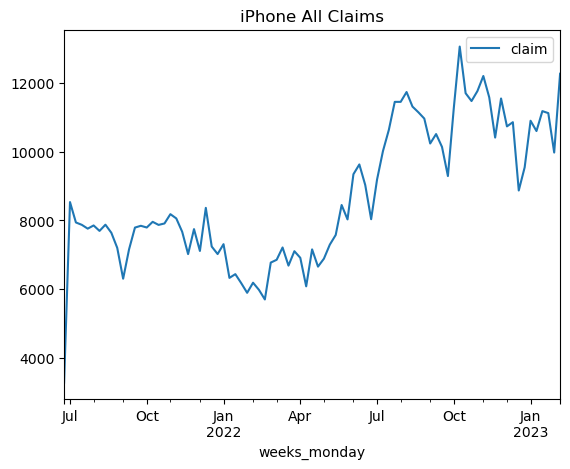

In [11]:
result_iphone_all.plot()
plt.title("iPhone All Claims")
# Plot has x-axis as weeks_monday

display(result_iphone_all)

## Testing for All iPhone Stationary - Augmented Dickey-Fuller Test

#### As seen in 43.1-modeling-ARIMA-Stationary-Test, we've already tested stationary on most of the iPhone subsets, so we're currently testing it on the sum of all iPhone claims

In [12]:
# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary
# The test results are interpreted with a p-value if p > 0.05 fails to reject the null hypothesis, 
# else if p <= 0.05 reject the null hypothesis.

values = result_iphone_all.values
 
# passing the extracted value count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

# p-value is 0.725656, which is greater than 0.05, so we fail to reject the null hypothesis at 90%, 95%, and 99% confidence,
# meaning the time series data is strongly non-stationary. Thus, the ADF test suggests our data is non-stationary

Augmneted Dickey_fuller Statistic: -1.073160
p-value: 0.725656
critical values at different levels:
	1%: -3.512
	5%: -2.897
	10%: -2.586


In [13]:
# Applying log function to see if ADF shows there is stationary data

# Ho (Null Hypothesis): The time series data is non-stationary
# H1 (alternate Hypothesis): The time series data is stationary
# The test results are interpreted with a p-value if p > 0.05 fails to reject the null hypothesis, 
# else if p <= 0.05 reject the null hypothesis.

# values function and applying log transform on it.
values = np.log(result_iphone_all.values)
 
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# printing the critical values at different alpha levels.
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

# p-value is 0.692380, which is greater than 0.05, so we fail to reject the null hypothesis at 90%, 95%, and 99% confidence,
# meaning the time series data is strongly non-stationary. Thus, the ADF test suggests our data is non-stationary. 

Augmneted Dickey_fuller Statistic: -1.155645
p-value: 0.692380
critical values at different levels:
	1%: -3.512
	5%: -2.897
	10%: -2.586


In [14]:
# Testing stationary through the ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(result_iphone_all)

# This verifies that our data is non-stationary and that we should use difference, so we expect for d to be > 0

(0.5613301433498991, True)

## Methods to find the p, d, q hyper parameters in ARIMA

In [15]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [16]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [17]:
# Preparing the data to use the ARIMA methods
result_iphone_all_v1 = result_iphone_all.copy()

result_iphone_all_v1['claim'] = result_iphone_all_v1['claim'].astype('float64')

# Apply log to the dataset as to try out this method for this notebook, this is log base e
# I am able to run this cell more than once as data is refreshedin same cell

result_iphone_all_v1['claim'] = np.log(result_iphone_all_v1['claim'])

display(result_iphone_all_v1)

,claim
weeks_monday,
2021-06-28,8.093462
2021-07-05,9.052048
2021-07-12,8.979920
2021-07-19,8.971194
2021-07-26,8.956995
...,...
2023-01-09,9.269364
2023-01-16,9.322686
2023-01-23,9.317489


# Create ARIMA Model on all iPhones Aggregated Data

In [18]:
# Split the training and testing data
# There is a log transformed version and the original version
train_all_log = result_iphone_all_v1[:68]
test_all_log = result_iphone_all_v1[-17:]

display(train_all_log)
display(test_all_log)

train_all = result_iphone_all[:68]
test_all = result_iphone_all[-17:]

display(train_all)
display(test_all)

,claim
weeks_monday,
2021-06-28,8.093462
2021-07-05,9.052048
2021-07-12,8.979920
2021-07-19,8.971194
2021-07-26,8.956995
...,...
2022-09-12,9.261033
2022-09-19,9.224736
2022-09-26,9.137339


,claim
weeks_monday,
2022-10-17,9.368284
2022-10-24,9.348623
2022-10-31,9.373649
2022-11-07,9.410256
2022-11-14,9.357898
2022-11-21,9.251290
2022-11-28,9.355133
2022-12-05,9.282103
2022-12-12,9.293394


,claim
weeks_monday,
2021-06-28,3273
2021-07-05,8536
2021-07-12,7942
2021-07-19,7873
2021-07-26,7762
...,...
2022-09-12,10520
2022-09-19,10145
2022-09-26,9296


,claim
weeks_monday,
2022-10-17,11711
2022-10-24,11483
2022-10-31,11774
2022-11-07,12213
2022-11-14,11590
2022-11-21,10418
2022-11-28,11558
2022-12-05,10744
2022-12-12,10866


Text(0.5, 1.0, 'All iPhone Claims as Train and Test Data')

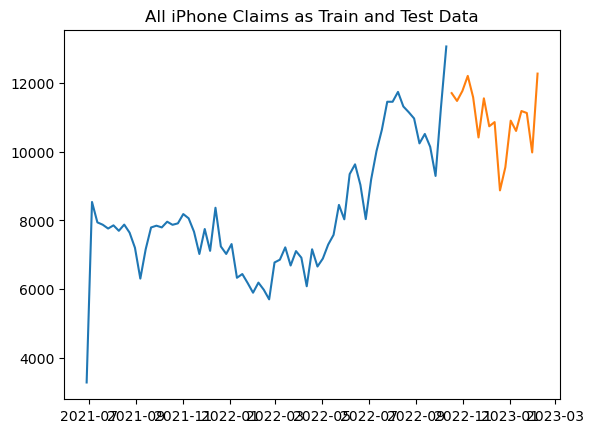

In [19]:
# Plotting to see what the iPhone Training and Test Data set split looks like as a quick check
plt.plot(train_all)
plt.plot(test_all)
plt.title("All iPhone Claims as Train and Test Data")

In [27]:
# This is utilizing the functions defined above to test it out and see whether the hyperparameters will help with the model
# evaluate parameters
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 3)
q_values = range(0, 6)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_all_v1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.113
ARIMA(0, 0, 1) MSE=0.047
ARIMA(0, 0, 2) MSE=0.031
ARIMA(0, 0, 3) MSE=0.027
ARIMA(0, 0, 4) MSE=0.023
ARIMA(0, 0, 5) MSE=0.019
ARIMA(0, 1, 0) MSE=0.009
ARIMA(0, 1, 1) MSE=0.008
ARIMA(0, 1, 2) MSE=0.008
ARIMA(0, 1, 3) MSE=0.009
ARIMA(0, 1, 4) MSE=0.009
ARIMA(0, 1, 5) MSE=0.009
ARIMA(0, 2, 0) MSE=0.019
ARIMA(0, 2, 1) MSE=0.009
ARIMA(0, 2, 2) MSE=0.009
ARIMA(0, 2, 3) MSE=0.009
ARIMA(0, 2, 4) MSE=0.012
ARIMA(0, 2, 5) MSE=0.012
ARIMA(1, 0, 0) MSE=0.012
ARIMA(1, 0, 1) MSE=0.010
ARIMA(1, 0, 2) MSE=0.010
ARIMA(1, 0, 3) MSE=0.011
ARIMA(1, 0, 4) MSE=0.014
ARIMA(1, 0, 5) MSE=0.015
ARIMA(1, 1, 0) MSE=0.009
ARIMA(1, 1, 1) MSE=0.008
ARIMA(1, 1, 2) MSE=0.008
ARIMA(1, 1, 3) MSE=0.008
ARIMA(1, 1, 4) MSE=0.009
ARIMA(1, 1, 5) MSE=0.009
ARIMA(1, 2, 0) MSE=0.016
ARIMA(1, 2, 1) MSE=0.009
ARIMA(1, 2, 2) MSE=0.009
ARIMA(1, 2, 3) MSE=0.008
ARIMA(1, 2, 4) MSE=0.009
ARIMA(1, 2, 5) MSE=0.011
ARIMA(2, 0, 0) MSE=0.011
ARIMA(2, 0, 1) MSE=0.011
ARIMA(2, 0, 2) MSE=0.014
ARIMA(2, 0, 3) MSE=0.010


In [28]:
# The model came back with ARIMA(1, 2, 3) MSE=0.008 as the best, but we fine tuned the model to be 1,1,5 after making further 
# adjustments

## Apply it on the training data
model_all = ARIMA(train_all_log, order=(1,1,5))
model_fit_all = model_all.fit()
print(model_fit_all.summary())

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   68
Model:                 ARIMA(1, 1, 5)   Log Likelihood                  37.342
Date:                Sun, 16 Apr 2023   AIC                            -60.684
Time:                        15:17:16   BIC                            -45.252
Sample:                    06-28-2021   HQIC                           -54.578
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2072     32.876     -0.006      0.995     -64.643      64.228
ma.L1         -0.1656     32.886     -0.005      0.996     -64.622      64.291
ma.L2         -0.0494     12.259     -0.004      0.9

In [21]:
prediction_all = pd.DataFrame(model_fit_all.forecast(len(test_all)+7))
prediction_all.columns = ['predicted_values']
prediction_all

,predicted_values
2022-10-17,9.408333
2022-10-24,9.424824
2022-10-31,9.410003
2022-11-07,9.391065
2022-11-14,9.392932
2022-11-21,9.392545
2022-11-28,9.392625
2022-12-05,9.392608
2022-12-12,9.392612
2022-12-19,9.392611


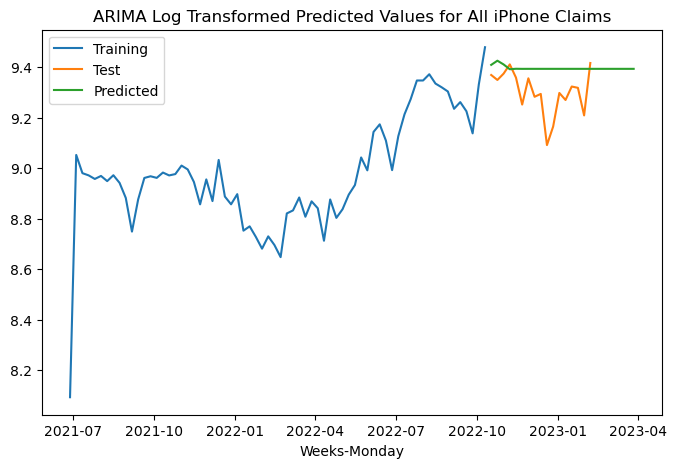

In [22]:
plt.figure(figsize=(8,5))
plt.plot(train_all_log,label="Training")
plt.plot(test_all_log,label="Test")
plt.plot(prediction_all,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Log Transformed Predicted Values for All iPhone Claims")
plt.xlabel("Weeks-Monday")
plt.show()

# y-axis is the log-transformed iPhone Claims

In [23]:
prediction_all_test = prediction_all.copy()

prediction_all_test['true_predicted_values'] = np.exp(prediction_all_test['predicted_values'])

display(prediction_all_test)

prediction_all_test = prediction_all_test.drop('predicted_values', axis = 1)

,predicted_values,true_predicted_values
2022-10-17,9.408333,12189.533049
2022-10-24,9.424824,12392.216004
2022-10-31,9.410003,12209.908282
2022-11-07,9.391065,11980.854113
2022-11-14,9.392932,12003.237150
2022-11-21,9.392545,11998.595490
2022-11-28,9.392625,11999.557191
2022-12-05,9.392608,11999.357900
2022-12-12,9.392612,11999.399197
2022-12-19,9.392611,11999.390639


Text(0.5, 0, 'Weeks-Monday')

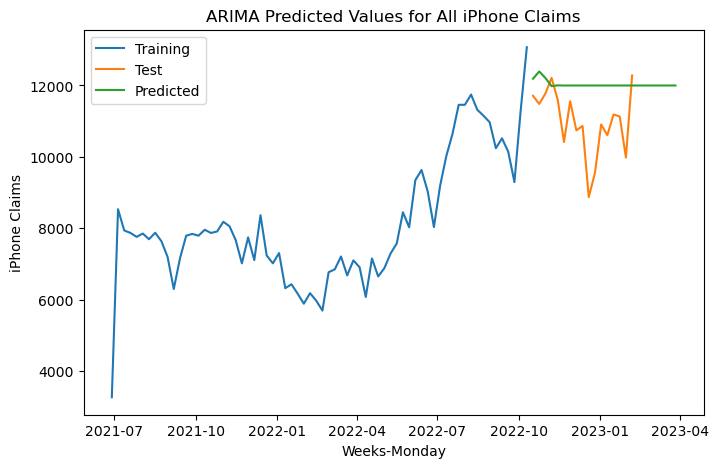

In [24]:
plt.figure(figsize=(8,5))
plt.plot(train_all,label="Training")
plt.plot(test_all,label="Test")
plt.plot(prediction_all_test,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for All iPhone Claims")
plt.ylabel("iPhone Claims")
plt.xlabel("Weeks-Monday")

In [25]:
prediction = prediction_all_test[-11:]

prediction.columns = ['predicted_values']
prediction

,predicted_values
2023-01-16,11999.392106
2023-01-23,11999.392109
2023-01-30,11999.392108
2023-02-06,11999.392108
2023-02-13,11999.392108
2023-02-20,11999.392108
2023-02-27,11999.392108
2023-03-06,11999.392108
2023-03-13,11999.392108
2023-03-20,11999.392108


In [455]:
calculation = prediction_all_test[0:17]

WMAPE_frames = [test_all, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['true_predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

# Calculate this model's WMAPE on the testing data which is all of the iPhone Aggregated Data
# WMAPE is 10.11

10.114198713107294

# Individual iPhone Predictions

#### Given the predictions on the aggregated iPhone claims data found above, we will subtract out the predictions of each of the models (SE, X, 11, 12, and 13) to see what's the model's values for iPhone 14. We will then compare the model's final remaining values to the iPhone 14's true values to see how well the model is doing and to predict the iPhone 14 values for March 2023.

##### Prediction for iPhone SE

In [37]:
result_iphone_se_v1 = result_iphone_se.copy()

result_iphone_se_v1['claim'] = result_iphone_se_v1['claim'].astype('float64')

# Apply log to the dataset 
result_iphone_se_v1['claim'] = np.log(result_iphone_se_v1['claim'])

display(result_iphone_se_v1)

,claim
weeks_monday,
2021-06-28,4.007333
2021-07-05,5.141664
2021-07-12,4.941642
2021-07-19,5.293305
2021-07-26,5.402677
...,...
2023-01-09,5.517453
2023-01-16,5.752573
2023-01-23,5.641907


In [38]:
# Split the training and testing data
# There is a log transformed version and the original version
train_se_log = result_iphone_se_v1[:68]
test_se_log = result_iphone_se_v1[-17:]

display(train_se_log)
display(test_se_log)

# Do about 80/20 split
train_se = result_iphone_se[:68]
test_se = result_iphone_se[-17:]


,claim
weeks_monday,
2021-06-28,4.007333
2021-07-05,5.141664
2021-07-12,4.941642
2021-07-19,5.293305
2021-07-26,5.402677
...,...
2022-09-12,5.568345
2022-09-19,5.739793
2022-09-26,5.713733


,claim
weeks_monday,
2022-10-17,5.877736
2022-10-24,5.762051
2022-10-31,5.934894
2022-11-07,6.037871
2022-11-14,4.615121
2022-11-21,4.204693
2022-11-28,4.174387
2022-12-05,4.007333
2022-12-12,3.433987


In [458]:
# This is utilizing the functions defined above to test it out and see whether the hyperparameters will help with the model
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_se_v1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.827
ARIMA(0, 0, 1) MSE=0.364
ARIMA(0, 0, 2) MSE=0.336
ARIMA(0, 0, 3) MSE=0.290
ARIMA(0, 1, 0) MSE=0.269
ARIMA(0, 1, 1) MSE=0.280
ARIMA(0, 1, 2) MSE=0.306
ARIMA(0, 1, 3) MSE=0.330
ARIMA(0, 2, 0) MSE=0.341
ARIMA(0, 2, 1) MSE=0.284
ARIMA(0, 2, 2) MSE=0.346
ARIMA(0, 2, 3) MSE=0.428
ARIMA(1, 0, 0) MSE=0.274
ARIMA(1, 0, 1) MSE=0.274
ARIMA(1, 0, 2) MSE=0.300
ARIMA(1, 0, 3) MSE=0.309
ARIMA(1, 1, 0) MSE=0.289
ARIMA(1, 1, 1) MSE=0.290
ARIMA(1, 1, 2) MSE=0.308
ARIMA(1, 1, 3) MSE=0.333
ARIMA(1, 2, 0) MSE=0.345
ARIMA(1, 2, 1) MSE=0.313
ARIMA(1, 2, 2) MSE=0.296
ARIMA(1, 2, 3) MSE=0.447
ARIMA(2, 0, 0) MSE=0.281
ARIMA(2, 0, 1) MSE=0.308
ARIMA(2, 0, 2) MSE=0.320
ARIMA(2, 0, 3) MSE=0.325
ARIMA(2, 1, 0) MSE=0.294
ARIMA(2, 1, 1) MSE=0.293
ARIMA(2, 1, 2) MSE=0.273
ARIMA(2, 1, 3) MSE=0.313
ARIMA(2, 2, 0) MSE=0.361
ARIMA(2, 2, 1) MSE=0.397
ARIMA(2, 2, 2) MSE=0.390
ARIMA(2, 2, 3) MSE=0.372
ARIMA(4, 0, 0) MSE=0.334
ARIMA(4, 0, 1) MSE=0.343
ARIMA(4, 0, 2) MSE=0.371
ARIMA(4, 0, 3) MSE=0.293


In [39]:
# Best ARIMA(0, 1, 0) MSE=0.269

model_se = ARIMA(train_se_log, order=(0,1,0))
model_fit_se = model_se.fit()
print(model_fit_se.summary())

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   68
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  17.524
Date:                Thu, 13 Apr 2023   AIC                            -33.048
Time:                        01:13:12   BIC                            -30.844
Sample:                    06-28-2021   HQIC                           -32.176
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0347      0.002     18.366      0.000       0.031       0.038
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):               923.24
Prob(Q):                              0.17   Pr

In [40]:
prediction_se = pd.DataFrame(model_fit_se.forecast(len(test_se)+7))
prediction_se.columns = ['predicted_values']
prediction_se

,predicted_values
2022-10-17,5.981414
2022-10-24,5.981414
2022-10-31,5.981414
2022-11-07,5.981414
2022-11-14,5.981414
2022-11-21,5.981414
2022-11-28,5.981414
2022-12-05,5.981414
2022-12-12,5.981414
2022-12-19,5.981414


In [42]:
prediction_se_test = prediction_se.copy()

# Transform the values back from the log transformation
prediction_se_test['true_predicted_values'] = np.exp(prediction_se_test['predicted_values'])

display(prediction_se_test)

prediction_se_test = prediction_se_test.drop('predicted_values', axis = 1)

,predicted_values,true_predicted_values
2022-10-17,5.981414,396.0
2022-10-24,5.981414,396.0
2022-10-31,5.981414,396.0
2022-11-07,5.981414,396.0
2022-11-14,5.981414,396.0
2022-11-21,5.981414,396.0
2022-11-28,5.981414,396.0
2022-12-05,5.981414,396.0
2022-12-12,5.981414,396.0
2022-12-19,5.981414,396.0


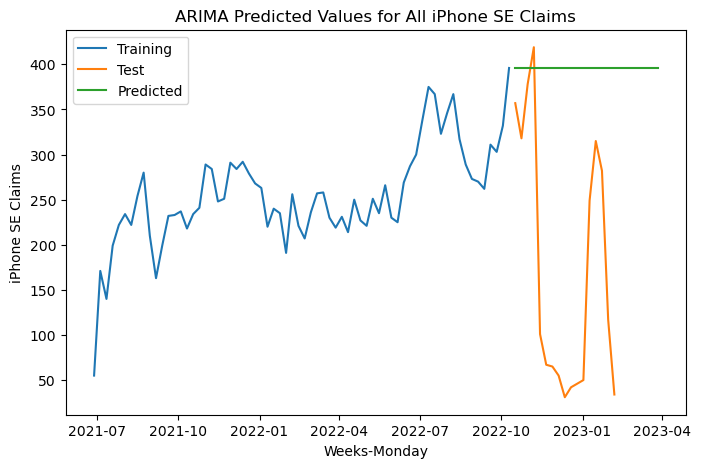

In [44]:
plt.figure(figsize=(8,5))
plt.plot(train_se,label="Training")
plt.plot(test_se,label="Test")
plt.plot(prediction_se_test,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for All iPhone SE Claims")
plt.ylabel("iPhone SE Claims")
plt.xlabel("Weeks-Monday")
plt.show()

In [45]:
# Subset prediction_se on just March data
prediction_se = prediction_se_test[-11:]

prediction_se.columns = ['predicted_values']
prediction_se

,predicted_values
2023-01-16,396.0
2023-01-23,396.0
2023-01-30,396.0
2023-02-06,396.0
2023-02-13,396.0
2023-02-20,396.0
2023-02-27,396.0
2023-03-06,396.0
2023-03-13,396.0
2023-03-20,396.0


##### Prediction for iPhone X

In [47]:
result_iphone_x_v1 = result_iphone_x.copy()

result_iphone_x_v1['claim'] = result_iphone_x_v1['claim'].astype('float64')

# Apply log to the dataset
result_iphone_x_v1['claim'] = np.log(result_iphone_x_v1['claim'])

display(result_iphone_x_v1)

,claim
weeks_monday,
2021-06-28,7.167809
2021-07-05,8.095599
2021-07-12,8.007700
2021-07-19,7.960673
2021-07-26,7.937375
...,...
2023-01-09,6.759255
2023-01-16,6.748760
2023-01-23,6.703188


In [48]:
# Split the training and testing data
# There is a log transformed version and the original version
train_x_log = result_iphone_x_v1[:68]
test_x_log = result_iphone_x_v1[-17:]

display(train_x_log)
display(test_x_log)

# Do about 80/20 split
train_x = result_iphone_x[:68]
test_x = result_iphone_x[-17:]


,claim
weeks_monday,
2021-06-28,7.167809
2021-07-05,8.095599
2021-07-12,8.007700
2021-07-19,7.960673
2021-07-26,7.937375
...,...
2022-09-12,6.995766
2022-09-19,6.921658
2022-09-26,6.863803


,claim
weeks_monday,
2022-10-17,7.125283
2022-10-24,7.037906
2022-10-31,7.038784
2022-11-07,7.129298
2022-11-14,7.020191
2022-11-21,6.889591
2022-11-28,7.067320
2022-12-05,6.912743
2022-12-12,6.909753


In [466]:
# This is utilizing the functions defined above to test it out and see whether the hyperparameters will help with the model
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_x_v1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.145
ARIMA(0, 0, 1) MSE=0.047
ARIMA(0, 0, 2) MSE=0.028
ARIMA(0, 0, 3) MSE=0.023
ARIMA(0, 1, 0) MSE=0.010
ARIMA(0, 1, 1) MSE=0.010
ARIMA(0, 1, 2) MSE=0.010
ARIMA(0, 1, 3) MSE=0.010
ARIMA(0, 2, 0) MSE=0.021
ARIMA(0, 2, 1) MSE=0.010
ARIMA(0, 2, 2) MSE=0.010
ARIMA(0, 2, 3) MSE=0.010
ARIMA(1, 0, 0) MSE=0.012
ARIMA(1, 0, 1) MSE=0.011
ARIMA(1, 0, 2) MSE=0.012
ARIMA(1, 0, 3) MSE=0.012
ARIMA(1, 1, 0) MSE=0.010
ARIMA(1, 1, 1) MSE=0.010
ARIMA(1, 1, 2) MSE=0.010
ARIMA(1, 1, 3) MSE=0.010
ARIMA(1, 2, 0) MSE=0.018
ARIMA(1, 2, 1) MSE=0.010
ARIMA(1, 2, 2) MSE=0.010
ARIMA(1, 2, 3) MSE=0.010
ARIMA(2, 0, 0) MSE=0.012
ARIMA(2, 0, 1) MSE=0.012
ARIMA(2, 0, 2) MSE=0.011
ARIMA(2, 0, 3) MSE=0.011
ARIMA(2, 1, 0) MSE=0.010
ARIMA(2, 1, 1) MSE=0.010
ARIMA(2, 1, 2) MSE=0.010
ARIMA(2, 1, 3) MSE=0.011
ARIMA(2, 2, 0) MSE=0.015
ARIMA(2, 2, 1) MSE=0.010
ARIMA(2, 2, 2) MSE=0.010
ARIMA(2, 2, 3) MSE=0.012
ARIMA(4, 0, 0) MSE=0.012
ARIMA(4, 0, 1) MSE=0.012
ARIMA(4, 0, 2) MSE=0.013
ARIMA(4, 0, 3) MSE=0.010


In [51]:
# Best ARIMA(1, 1, 2) MSE=0.010, but we adjusted the p, d, q as part of fine-tuning
model_x = ARIMA(train_x_log, order=(4,2,1))
model_fit_x = model_x.fit()
print(model_fit_x.summary())

prediction_x = pd.DataFrame(model_fit_x.forecast(len(test_x)+7))
prediction_x.columns = ['predicted_values']

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   68
Model:                 ARIMA(4, 2, 1)   Log Likelihood                  21.639
Date:                Thu, 13 Apr 2023   AIC                            -31.277
Time:                        01:16:48   BIC                            -18.139
Sample:                    06-28-2021   HQIC                           -26.086
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1908      0.143     -1.333      0.183      -0.471       0.090
ar.L2         -0.0757      0.159     -0.475      0.635      -0.388       0.237
ar.L3         -0.0942      0.140     -0.675      0.5

In [52]:
prediction_x_test = prediction_x.copy()

# Transform the values back from the log transformation
prediction_x_test['true_predicted_values'] = np.exp(prediction_x_test['predicted_values'])

display(prediction_x_test)

prediction_x_test = prediction_x_test.drop('predicted_values', axis = 1)

,predicted_values,true_predicted_values
2022-10-17,7.207353,1349.315931
2022-10-24,7.183591,1317.630878
2022-10-31,7.144672,1267.335242
2022-11-07,7.130053,1248.942825
2022-11-14,7.137239,1257.950150
2022-11-21,7.137652,1258.469589
2022-11-28,7.137191,1257.890454
2022-12-05,7.132510,1252.015610
2022-12-12,7.126785,1244.868579
2022-12-19,7.122454,1239.488825


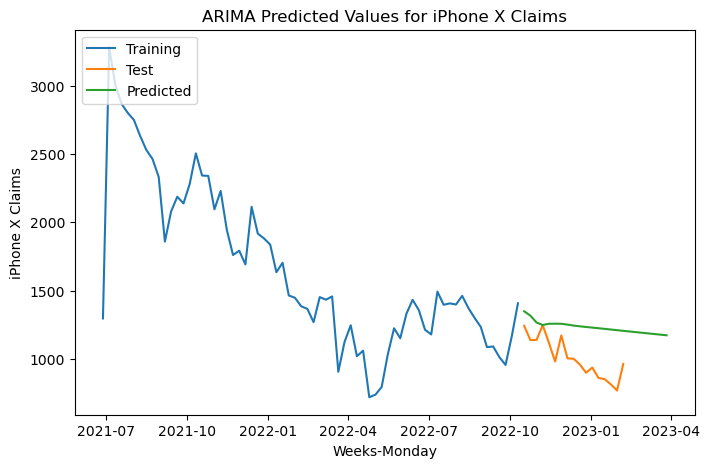

In [53]:
plt.figure(figsize=(8,5))
plt.plot(train_x,label="Training")
plt.plot(test_x,label="Test")
plt.plot(prediction_x_test,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone X Claims")
plt.ylabel("iPhone X Claims")
plt.xlabel("Weeks-Monday")
plt.show()

In [54]:
# Subset prediction_x on just March data
prediction_x = prediction_x_test[-11:]

prediction_x.columns = ['predicted_values']
prediction_x

,predicted_values
2023-01-16,1220.764965
2023-01-23,1215.967506
2023-01-30,1211.166794
2023-02-06,1206.431196
2023-02-13,1201.738937
2023-02-20,1197.062938
2023-02-27,1192.401896
2023-03-06,1187.752135
2023-03-13,1183.119377
2023-03-20,1178.505950


##### Prediction for iPhone 11

In [55]:
result_iphone_11_v1 = result_iphone_11.copy()

result_iphone_11_v1['claim'] = result_iphone_11_v1['claim'].astype('float64')

# Apply log to the dataset
result_iphone_11_v1['claim'] = np.log(result_iphone_11_v1['claim'])

display(result_iphone_11_v1)

,claim
weeks_monday,
2021-06-28,7.312553
2021-07-05,8.310907
2021-07-12,8.230311
2021-07-19,8.206311
2021-07-26,8.183956
...,...
2023-01-09,7.529943
2023-01-16,7.526179
2023-01-23,7.467942


In [56]:
# Split the training and testing data
# There is a log transformed version and the original version
train_11_log = result_iphone_11_v1[:68]
test_11_log = result_iphone_11_v1[-17:]

display(train_11_log)
display(test_11_log)

# Do about 80/20 split
train_11 = result_iphone_11[:68]
test_11 = result_iphone_11[-17:]

,claim
weeks_monday,
2021-06-28,7.312553
2021-07-05,8.310907
2021-07-12,8.230311
2021-07-19,8.206311
2021-07-26,8.183956
...,...
2022-09-12,7.743703
2022-09-19,7.695758
2022-09-26,7.578145


,claim
weeks_monday,
2022-10-17,7.861342
2022-10-24,7.776954
2022-10-31,7.835579
2022-11-07,7.870930
2022-11-14,7.830823
2022-11-21,7.682022
2022-11-28,7.797702
2022-12-05,7.737180
2022-12-12,7.802618


In [473]:
# This is utilizing the functions defined above to test it out and see whether the hyperparameters will help with the model
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_11_v1.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=0.051
ARIMA(0, 0, 1) MSE=0.022
ARIMA(0, 0, 2) MSE=0.017
ARIMA(0, 0, 3) MSE=0.023
ARIMA(0, 1, 0) MSE=0.012
ARIMA(0, 1, 1) MSE=0.012
ARIMA(0, 1, 2) MSE=0.012
ARIMA(0, 1, 3) MSE=0.012
ARIMA(0, 2, 0) MSE=0.024
ARIMA(0, 2, 1) MSE=0.013
ARIMA(0, 2, 2) MSE=0.013
ARIMA(0, 2, 3) MSE=0.014
ARIMA(1, 0, 0) MSE=0.012
ARIMA(1, 0, 1) MSE=0.012
ARIMA(1, 0, 2) MSE=0.013
ARIMA(1, 0, 3) MSE=0.013
ARIMA(1, 1, 0) MSE=0.013
ARIMA(1, 1, 1) MSE=0.012
ARIMA(1, 1, 2) MSE=0.013
ARIMA(1, 1, 3) MSE=0.012
ARIMA(1, 2, 0) MSE=0.021
ARIMA(1, 2, 1) MSE=0.013
ARIMA(1, 2, 2) MSE=0.015
ARIMA(1, 2, 3) MSE=0.013
ARIMA(2, 0, 0) MSE=0.013
ARIMA(2, 0, 1) MSE=0.013
ARIMA(2, 0, 2) MSE=0.013
ARIMA(2, 0, 3) MSE=0.013
ARIMA(2, 1, 0) MSE=0.012
ARIMA(2, 1, 1) MSE=0.013
ARIMA(2, 1, 2) MSE=0.013
ARIMA(2, 1, 3) MSE=0.013
ARIMA(2, 2, 0) MSE=0.019
ARIMA(2, 2, 1) MSE=0.013
ARIMA(2, 2, 2) MSE=0.015
ARIMA(2, 2, 3) MSE=0.015
ARIMA(4, 0, 0) MSE=0.013
ARIMA(4, 0, 1) MSE=0.013
ARIMA(4, 0, 2) MSE=0.014
ARIMA(4, 0, 3) MSE=0.014


In [57]:
# Best ARIMA(0, 1, 1) MSE=0.012 but we switched the p, d, q values as part of hyperparameter tuning
model_11 = ARIMA(train_11_log, order=(5,1,0))
model_fit_11 = model_11.fit()
print(model_fit_11.summary())

prediction_11 = pd.DataFrame(model_fit_11.forecast(len(test_11)+7))
prediction_11.columns = ['predicted_values']

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   68
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  35.010
Date:                Thu, 13 Apr 2023   AIC                            -58.019
Time:                        01:22:34   BIC                            -44.791
Sample:                    06-28-2021   HQIC                           -52.785
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4579      0.133     -3.430      0.001      -0.720      -0.196
ar.L2         -0.2465      0.234     -1.054      0.292      -0.705       0.212
ar.L3         -0.1568      0.314     -0.499      0.6

In [58]:
prediction_11_test = prediction_11.copy()

# Transform the values back from the log transformation
prediction_11_test['true_predicted_values'] = np.exp(prediction_11_test['predicted_values'])

display(prediction_11_test)

prediction_11_test = prediction_11_test.drop('predicted_values', axis = 1)

,predicted_values,true_predicted_values
2022-10-17,7.869486,2616.221346
2022-10-24,7.857421,2584.845894
2022-10-31,7.851322,2569.127734
2022-11-07,7.841913,2545.069013
2022-11-14,7.847159,2558.454314
2022-11-21,7.857830,2585.901629
2022-11-28,7.854583,2577.521073
2022-12-05,7.853937,2575.856029
2022-12-12,7.853574,2574.921606
2022-12-19,7.853035,2573.533661


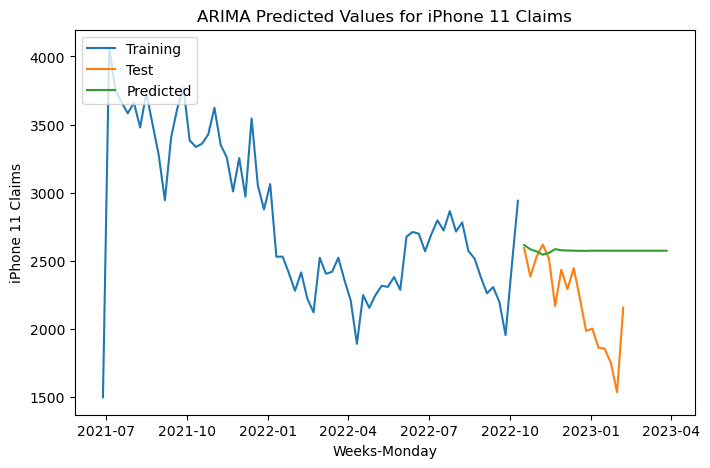

In [59]:
plt.figure(figsize=(8,5))
plt.plot(train_11,label="Training")
plt.plot(test_11,label="Test")
plt.plot(prediction_11_test,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 11 Claims")
plt.ylabel("iPhone 11 Claims")
plt.xlabel("Weeks-Monday")
plt.show()

In [60]:
# Subset prediction_11 on just March data
prediction_11 = prediction_11_test[-11:]

prediction_11.columns = ['predicted_values']
prediction_11

,predicted_values
2023-01-16,2574.532827
2023-01-23,2574.495423
2023-01-30,2574.433540
2023-02-06,2574.392483
2023-02-13,2574.446986
2023-02-20,2574.448345
2023-02-27,2574.449209
2023-03-06,2574.448311
2023-03-13,2574.446315
2023-03-20,2574.443145


##### Prediction for iPhone 12

In [61]:
result_iphone_12_v1 = result_iphone_12.copy()

result_iphone_12_v1['claim'] = result_iphone_12_v1['claim'].astype('float64')

# Apply log to the dataset 
result_iphone_12_v1['claim'] = np.log(result_iphone_12_v1['claim'])

display(result_iphone_12_v1)

,claim
weeks_monday,
2021-06-28,6.045005
2021-07-05,6.924612
2021-07-12,6.951772
2021-07-19,7.042286
2021-07-26,7.053586
...,...
2023-01-09,8.283747
2023-01-16,8.361007
2023-01-23,8.327484


In [62]:
# Split the training and testing data
# There is a log transformed version and the original version
train_12_log = result_iphone_12_v1[:68]
test_12_log = result_iphone_12_v1[-17:]

display(train_12_log)
display(test_12_log)

# Do about 80/20 split
train_12 = result_iphone_12[:68]
test_12 = result_iphone_12[-17:]

,claim
weeks_monday,
2021-06-28,6.045005
2021-07-05,6.924612
2021-07-12,6.951772
2021-07-19,7.042286
2021-07-26,7.053586
...,...
2022-09-12,8.265136
2022-09-19,8.231908
2022-09-26,8.119696


,claim
weeks_monday,
2022-10-17,8.316789
2022-10-24,8.325306
2022-10-31,8.359837
2022-11-07,8.411833
2022-11-14,8.413831
2022-11-21,8.315322
2022-11-28,8.374246
2022-12-05,8.308446
2022-12-12,8.350194


In [480]:
# This is utilizing the functions defined above to test it out and see whether the hyperparameters will help with the model
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_12_v1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.336
ARIMA(0, 0, 1) MSE=0.117
ARIMA(0, 0, 2) MSE=0.079
ARIMA(0, 0, 3) MSE=0.049
ARIMA(0, 1, 0) MSE=0.011
ARIMA(0, 1, 1) MSE=0.010
ARIMA(0, 1, 2) MSE=0.011
ARIMA(0, 1, 3) MSE=0.012
ARIMA(0, 2, 0) MSE=0.026
ARIMA(0, 2, 1) MSE=0.012
ARIMA(0, 2, 2) MSE=0.011
ARIMA(0, 2, 3) MSE=0.011
ARIMA(1, 0, 0) MSE=0.011
ARIMA(1, 0, 1) MSE=0.011
ARIMA(1, 0, 2) MSE=0.011
ARIMA(1, 0, 3) MSE=0.012
ARIMA(1, 1, 0) MSE=0.010
ARIMA(1, 1, 1) MSE=0.011
ARIMA(1, 1, 2) MSE=0.012
ARIMA(1, 1, 3) MSE=0.012
ARIMA(1, 2, 0) MSE=0.020
ARIMA(1, 2, 1) MSE=0.011
ARIMA(1, 2, 2) MSE=0.012
ARIMA(1, 2, 3) MSE=0.012
ARIMA(2, 0, 0) MSE=0.011
ARIMA(2, 0, 1) MSE=0.011
ARIMA(2, 0, 2) MSE=0.012
ARIMA(2, 0, 3) MSE=0.012
ARIMA(2, 1, 0) MSE=0.011
ARIMA(2, 1, 1) MSE=0.011
ARIMA(2, 1, 2) MSE=0.012
ARIMA(2, 1, 3) MSE=0.011
ARIMA(2, 2, 0) MSE=0.016
ARIMA(2, 2, 1) MSE=0.011
ARIMA(2, 2, 2) MSE=0.012
ARIMA(2, 2, 3) MSE=0.013
ARIMA(4, 0, 0) MSE=0.012
ARIMA(4, 0, 1) MSE=0.012
ARIMA(4, 0, 2) MSE=0.015
ARIMA(4, 0, 3) MSE=0.013


In [63]:
# Best ARIMA(0, 1, 1)) MSE=0.010 - adjusted the p, d, q as hyperparameters
model_12 = ARIMA(train_12_log, order=(1,0,0))
model_fit_12 = model_12.fit()
print(model_fit_12.summary())

prediction_12 = pd.DataFrame(model_fit_12.forecast(len(test_12)+7))
prediction_12.columns = ['predicted_values']

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   68
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  31.350
Date:                Thu, 13 Apr 2023   AIC                            -56.700
Time:                        02:12:32   BIC                            -50.042
Sample:                    06-28-2021   HQIC                           -54.062
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3931      0.999      7.404      0.000       5.436       9.350
ar.L1          0.9885      0.032     30.690      0.000       0.925       1.052
sigma2         0.0220      0.002      9.994      0.0

In [64]:
prediction_12_test = prediction_12.copy()

# Transform the values back from the log transformation
prediction_12_test['true_predicted_values'] = np.exp(prediction_12_test['predicted_values'])

display(prediction_12_test)

prediction_12_test = prediction_12_test.drop('predicted_values', axis = 1)

,predicted_values,true_predicted_values
2022-10-17,8.451731,4683.170041
2022-10-24,8.439598,4626.696169
2022-10-31,8.427605,4571.538872
2022-11-07,8.415749,4517.660008
2022-11-14,8.404030,4465.022754
2022-11-21,8.392444,4413.591550
2022-11-28,8.380991,4363.332050
2022-12-05,8.369670,4314.211078
2022-12-12,8.358478,4266.196576
2022-12-19,8.347414,4219.257565


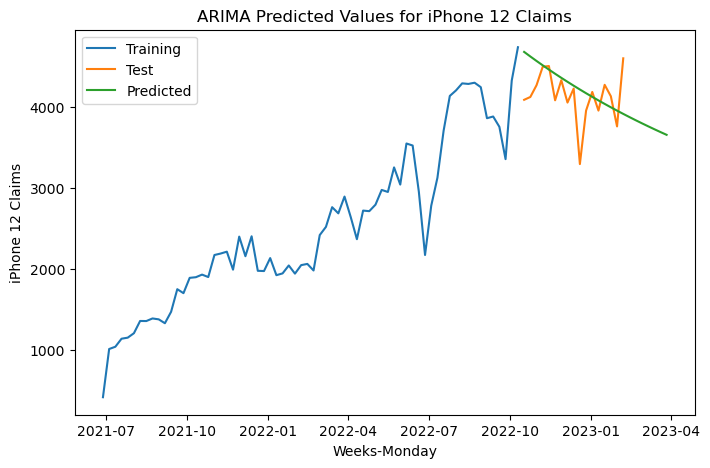

In [65]:
plt.figure(figsize=(8,5))
plt.plot(train_12,label="Training")
plt.plot(test_12,label="Test")
plt.plot(prediction_12_test,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 12 Claims")
plt.ylabel("iPhone 12 Claims")
plt.xlabel("Weeks-Monday")

plt.show()

In [66]:
# Subset prediction_12 on just March data
prediction_12 = prediction_12_test[-11:]

prediction_12.columns = ['predicted_values']
prediction_12

,predicted_values
2023-01-16,4041.672307
2023-01-23,3999.680979
2023-01-30,3958.599694
2023-02-06,3918.403944
2023-02-13,3879.070014
2023-02-20,3840.574951
2023-02-27,3802.896532
2023-03-06,3766.013241
2023-03-13,3729.904243
2023-03-20,3694.549358


##### Prediction for iPhone 13

In [68]:
result_iphone_13_v1 = result_iphone_13.copy()

result_iphone_13_v1['claim'] = result_iphone_13_v1['claim'].astype('float64')

# Apply log to the dataset

result_iphone_13_v1['claim'] = np.log(result_iphone_13_v1['claim'])

display(result_iphone_13_v1)

,claim
weeks_monday,
2021-11-15,0.693147
2021-11-22,1.098612
2021-11-29,1.791759
2021-12-06,0.693147
2021-12-13,2.302585
...,...
2023-01-09,8.193124
2023-01-16,8.250098
2023-01-23,8.316300


In [69]:
# Split the training and testing data
# There is a log transformed version and the original version
train_13_log = result_iphone_13_v1[:51]
test_13_log = result_iphone_13_v1[-14:]

display(train_13_log)
display(test_13_log)

# Do about 80/20 split
train_13 = result_iphone_13[:51]
test_13 = result_iphone_13[-14:]

,claim
weeks_monday,
2021-11-15,0.693147
2021-11-22,1.098612
2021-11-29,1.791759
2021-12-06,0.693147
2021-12-13,2.302585
2021-12-20,1.791759
2021-12-27,2.708050
2022-01-03,1.945910
2022-01-10,2.564949


,claim
weeks_monday,
2022-11-07,8.139149
2022-11-14,8.112228
2022-11-21,8.033983
2022-11-28,8.168486
2022-12-05,8.098947
2022-12-12,8.046549
2022-12-19,7.745868
2022-12-26,7.869402
2023-01-02,8.211483


In [70]:
# This is utilizing the functions defined above to test it out and see whether the hyperparameters will help with the model
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_13_v1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=4.791
ARIMA(0, 0, 1) MSE=1.429
ARIMA(0, 0, 2) MSE=0.608
ARIMA(0, 0, 3) MSE=0.302
ARIMA(0, 1, 0) MSE=0.015
ARIMA(0, 1, 1) MSE=0.015
ARIMA(0, 1, 2) MSE=0.022
ARIMA(0, 1, 3) MSE=0.022
ARIMA(0, 2, 0) MSE=0.031
ARIMA(0, 2, 1) MSE=0.021
ARIMA(0, 2, 2) MSE=0.018
ARIMA(0, 2, 3) MSE=0.021
ARIMA(1, 0, 0) MSE=0.017
ARIMA(1, 0, 1) MSE=0.016
ARIMA(1, 0, 2) MSE=0.024
ARIMA(1, 0, 3) MSE=0.024
ARIMA(1, 1, 0) MSE=0.016
ARIMA(1, 1, 1) MSE=0.017
ARIMA(1, 1, 2) MSE=0.019
ARIMA(1, 1, 3) MSE=0.020
ARIMA(1, 2, 0) MSE=0.031
ARIMA(1, 2, 1) MSE=0.021
ARIMA(1, 2, 2) MSE=0.021
ARIMA(1, 2, 3) MSE=0.020
ARIMA(2, 0, 0) MSE=0.017
ARIMA(2, 0, 1) MSE=0.018
ARIMA(2, 0, 2) MSE=0.020
ARIMA(2, 0, 3) MSE=0.044
ARIMA(2, 1, 0) MSE=0.021
ARIMA(2, 1, 1) MSE=0.021
ARIMA(2, 1, 2) MSE=0.020
ARIMA(2, 1, 3) MSE=0.021
ARIMA(2, 2, 0) MSE=0.030
ARIMA(2, 2, 1) MSE=0.022
ARIMA(2, 2, 2) MSE=0.021
ARIMA(2, 2, 3) MSE=0.023
ARIMA(4, 0, 0) MSE=0.024
ARIMA(4, 0, 1) MSE=0.024
ARIMA(4, 0, 2) MSE=0.035
ARIMA(4, 0, 3) MSE=0.039


In [72]:
# Best ARIMA(0, 1, 1) MSE=0.015
model_13 = ARIMA(train_13_log, order=(0,1,1))
model_fit_13 = model_13.fit()
print(model_fit_13.summary())


prediction_13 = pd.DataFrame(model_fit_13.forecast(len(test_13)+7))
prediction_13.columns = ['predicted_values']

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   51
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -28.190
Date:                Thu, 13 Apr 2023   AIC                             60.380
Time:                        02:17:00   BIC                             64.204
Sample:                    11-15-2021   HQIC                            61.837
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1735      0.089     -1.939      0.053      -0.349       0.002
sigma2         0.1807      0.024      7.589      0.000       0.134       0.227
Ljung-Box (L1) (Q):                   5.39   Jarque-

In [73]:
prediction_13_test = prediction_13.copy()

# Transform the values back from the log transformation
prediction_13_test['true_predicted_values'] = np.exp(prediction_13_test['predicted_values'])

display(prediction_13_test)

prediction_13_test = prediction_13_test.drop('predicted_values', axis = 1)

,predicted_values,true_predicted_values
2022-11-07,8.149797,3462.677487
2022-11-14,8.149797,3462.677487
2022-11-21,8.149797,3462.677487
2022-11-28,8.149797,3462.677487
2022-12-05,8.149797,3462.677487
2022-12-12,8.149797,3462.677487
2022-12-19,8.149797,3462.677487
2022-12-26,8.149797,3462.677487
2023-01-02,8.149797,3462.677487
2023-01-09,8.149797,3462.677487


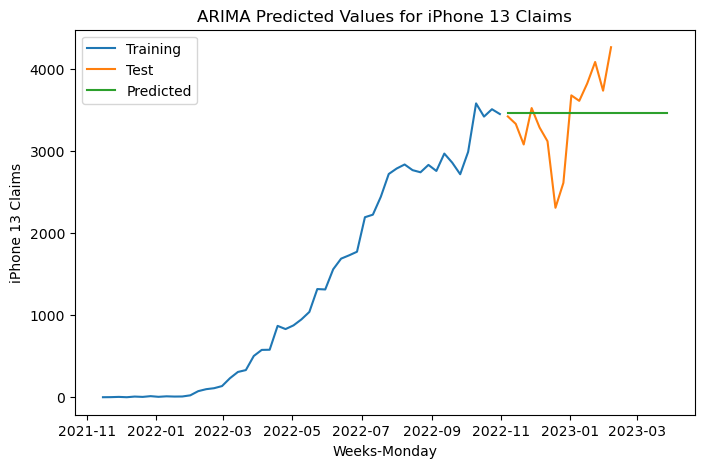

In [74]:
plt.figure(figsize=(8,5))
plt.plot(train_13,label="Training")
plt.plot(test_13,label="Test")
plt.plot(prediction_13_test,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 13 Claims")
plt.ylabel("iPhone 13 Claims")
plt.xlabel("Weeks-Monday")
plt.show()

In [75]:
# Subset prediction_13 on just March data
prediction_13 = prediction_13_test[-11:]

prediction_13.columns = ['predicted_values']
prediction_13

,predicted_values
2023-01-16,3462.677487
2023-01-23,3462.677487
2023-01-30,3462.677487
2023-02-06,3462.677487
2023-02-13,3462.677487
2023-02-20,3462.677487
2023-02-27,3462.677487
2023-03-06,3462.677487
2023-03-13,3462.677487
2023-03-20,3462.677487


#### Calcuating the iPhone 14 Prediction Values

In [26]:
# Contains 11 values - 4 for WMAPE test and the last four are for prediciton, the value count is correct to match everything up
# Predicted values of all iPhone Claims Data that was calculated earlier in the notebook. This contains 11 values. 4 of the
# values (1/16/23 - 2/6/23) are used to calculate the WMAPE value while the last 4 values (3/6/23 - 3/27/23) are used to 
# calcuate the iPhone 14 prediction values
prediction

,predicted_values
2023-01-16,11999.392106
2023-01-23,11999.392109
2023-01-30,11999.392108
2023-02-06,11999.392108
2023-02-13,11999.392108
2023-02-20,11999.392108
2023-02-27,11999.392108
2023-03-06,11999.392108
2023-03-13,11999.392108
2023-03-20,11999.392108


In [77]:
# Subracting the prediction values of iPhone SE, iPhone X, and iPhones 11-13 from the summation of all iPhone claims
# The final remaining result will show what are the model's predictions of iPhone 14
iphone_14_calc_predictions = prediction.subtract(prediction_se).subtract(prediction_x).subtract(prediction_11).subtract(prediction_12).subtract(prediction_13)

# This is the list of all predicted values for iPhone 14, we take the 1/16/23 - 2/6/23 values to calculate the WMAPE value
display(iphone_14_calc_predictions)

# This is showing the shortened dataframe of the true iPhone 14 data
df_test =  result_iphone_14[-4:]
display(df_test)

,predicted_values
2023-01-16,303.744520
2023-01-23,350.570713
2023-01-30,396.514593
2023-02-06,441.486999
2023-02-13,485.458685
2023-02-20,528.628388
2023-02-27,570.966985
2023-03-06,612.500934
2023-03-13,653.244686
2023-03-20,693.216169


,claim
weeks_monday,
2023-01-16,60
2023-01-23,57
2023-01-30,54
2023-02-06,251


In [79]:
calculation = iphone_14_calc_predictions[0:4]

WMAPE_frames = [df_test, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

# Ended up with a WMAPE of 253.62%, which is not good, but we have reason to speculate that the iPhone 14 data is on the curve
# about to spike upwards. Thus, we have reason to assume that the prediction iPhone 14 values are more accurate than what the
# WMAPE score is able to tell about the model

WMAPE

253.62957952421374

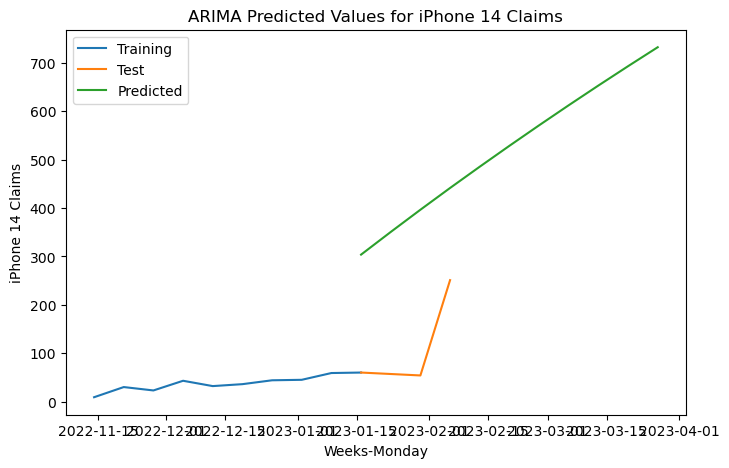

In [81]:
plt.figure(figsize=(8,5))
plt.plot(result_iphone_14[0:10],label="Training")
plt.plot(df_test,label="Test")
plt.plot(iphone_14_calc_predictions,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 14 Claims")
plt.ylabel("iPhone 14 Claims")
plt.xlabel("Weeks-Monday")
plt.show()